In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature

import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [3]:
# those three are created from storm cut out kernels (storm netcdf files needed!)

OBS3 = pkl.load( open ('/home/ck/DIR/cornkle/data/DYAMOND/UM-5km/MCS/WA/UM-5k_5000km2_-40_9-22N_tir_prcp.p', 'rb'))

In [4]:
OBS3.keys()

dict_keys(['hour', 'month', 'year', 'area', 'lon', 'lat', 'clon', 'clat', 'tmin', 'tmean', 'tcw', 'pmax', 'pmean', 't', 'p'])

In [5]:
np.unique(OBS3['year'])

array([2016])

In [6]:
def create_dic(dic):
    pp = np.array(dic['pmax'])
    pm = np.array(dic['pmean'])
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])
    hour = np.array(dic['hour'])
    tcw = np.array(dic['tcw'])


    obs_pcp = {
        'prcp' : pp,
        'pmean' : pm,
        'month' : month,
        'area' : (area)*(5**2),
        'tmin' : tt,
        'tmean' : ttm,
        'lat' : lat,
        'lon' : lon,
        'hour' : hour,
        'tcw' : tcw,
    } 
    obs = pd.DataFrame(obs_pcp)
    return obs

In [7]:
obs_gpm = create_dic(OBS3)

In [8]:
np.max(obs_gpm.lat)

21.7734375

In [9]:
obs_gpm.keys()

Index(['prcp', 'pmean', 'month', 'area', 'tmin', 'tmean', 'lat', 'lon', 'hour',
       'tcw'],
      dtype='object')

In [10]:
np.sum((obs_gpm['hour']<=19) & (obs_gpm['hour']>=13))

2070

In [11]:
np.sum((obs_gpm['hour']<=19) & (obs_gpm['hour']>=13)& (obs_gpm['prcp']>=5))

1764

In [12]:
obs_gpm = obs_gpm[(obs_gpm['hour']>=13) & (obs_gpm['prcp']>=5)]

In [13]:
len(obs_gpm)

2729

In [14]:


from scipy.stats import gaussian_kde

 

def calc_density(v1,v2):

    xy = np.vstack([v1, v2])

    z = gaussian_kde(xy)(xy)

    return z / (z.max() - z.min())


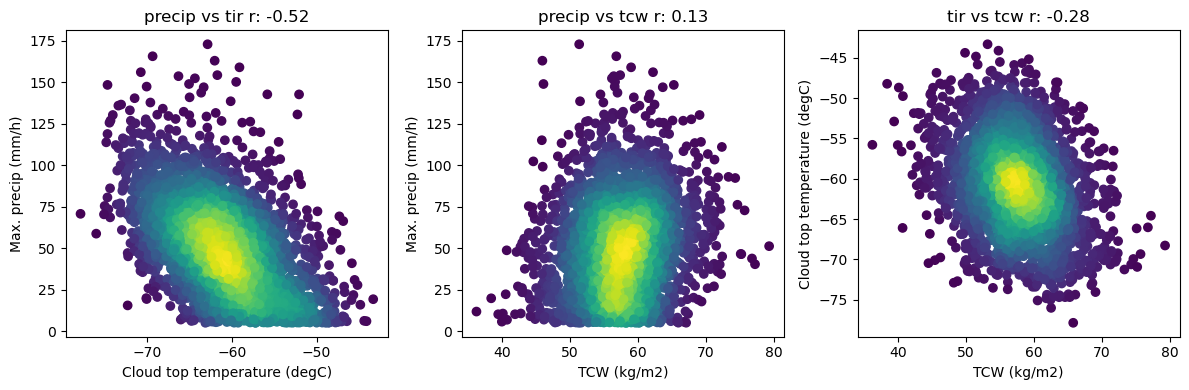

In [18]:

f = plt.figure(figsize=(12,4), dpi=100)
ax = f.add_subplot(131)
cp4s = [obs_gpm.tmin, obs_gpm.prcp] 
r = stats.pearsonr(cp4s[0],cp4s[1])
density = calc_density(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1], c=density)
plt.title('precip vs tir r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('Cloud top temperature (degC)')
plt.ylabel('Max. precip (mm/h)')

ax = f.add_subplot(132)
cp4s = [obs_gpm.tcw, obs_gpm.prcp] 
r = stats.pearsonr(cp4s[0],cp4s[1])
density = calc_density(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1], c=density)
plt.title('precip vs tcw r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('TCW (kg/m2)')
plt.ylabel('Max. precip (mm/h)')

ax = f.add_subplot(133)
cp4s = [obs_gpm.tcw, obs_gpm.tmin]
r = stats.pearsonr(cp4s[0],cp4s[1])
density = calc_density(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1], c=density)
plt.title('tir vs tcw r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('TCW (kg/m2)')
plt.ylabel('Cloud top temperature (degC)')
plt.tight_layout()
plt.savefig(cnst.network_data + 'figs/DYAMOND/dyamond_UM-5km_Sahel_scatter.jpg')

In [16]:
from endgame import hist2d
p_tcw = hist2d.var2_binning_mean(obs_gpm.tcw, obs_gpm.prcp, np.linspace(40,76,15))
pslope, pintercept, pr_value, pp_value, pstd_err = stats.linregress(p_tcw['xbins'], p_tcw['y'])
tir_tcw = hist2d.var2_binning_mean(obs_gpm.tcw, obs_gpm.tmin, np.linspace(40,76,15))
tslope, tintercept, tr_value, tp_value, tstd_err = stats.linregress(tir_tcw['xbins'], tir_tcw['y'])

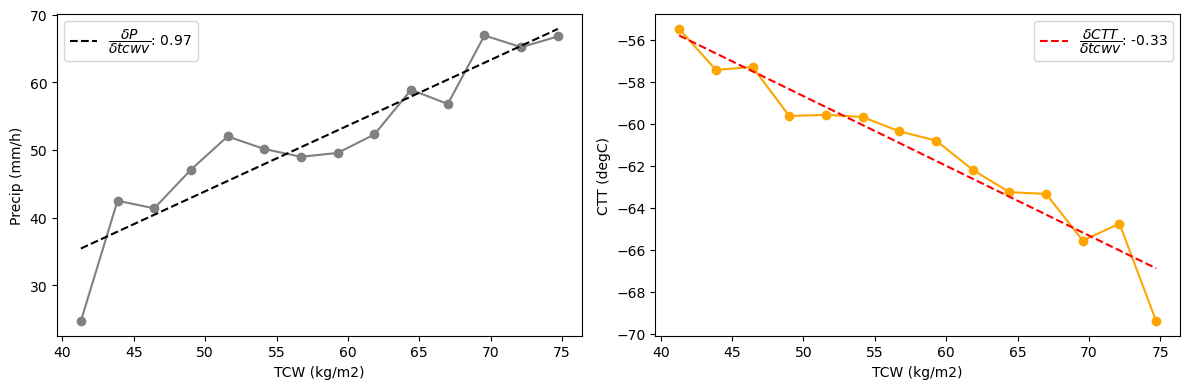

In [17]:
f = plt.figure(figsize=(12,4), dpi=100)
ax = f.add_subplot(121)
plt.plot(p_tcw['xbins'], p_tcw['y'], color='grey', marker='o')
plt.plot(p_tcw['xbins'], pintercept+np.array(p_tcw['xbins'])*pslope, linestyle='dashed', color='k', label=r'$\dfrac{\delta P}{\delta tcwv}$: ' + str(np.round(pslope,2)))
plt.xlabel('TCW (kg/m2)')
plt.ylabel('Precip (mm/h)')
plt.legend()

ax = f.add_subplot(122)
plt.plot(tir_tcw['xbins'], tir_tcw['y'], color='orange', marker='o')
plt.plot(tir_tcw['xbins'], tintercept+np.array(tir_tcw['xbins'])*tslope, linestyle='dashed', color='r', label=r'$\dfrac{\delta CTT}{\delta tcwv}$: ' + str(np.round(tslope,2)))
plt.xlabel('TCW (kg/m2)')
plt.ylabel('CTT (degC)')
plt.legend()
plt.tight_layout()
plt.savefig(cnst.network_data + 'figs/DYAMOND/dyamond_UM-5km_Sahel_averageScaling_TCWbin_unitCorrection.jpg')

In [151]:
ttag='hourly'
gpmf = ('obs' , cnst.CLOVER_SAVES +'bulk_-50_5000km2_GPM_5-26N_16W17E_p15_ERA0.7_TCWV_'+ttag+'_*.p') #+ 'bulk_-40_5000km2_GPM_ERA5_5-25N_p15_-40C_TCWV.p')#
dlist=[gpmf]

def create_dic_obs(dic):
    
    tt = np.array(dic['tmin'])
    mask = np.where(tt<=-50)
    
    pp = np.array(dic['pmax'])[mask]
    sh = np.array(dic['shear'])[mask] #np.array(dic['shear']) * (-1)
    umin = np.array(dic['u650'])[mask]
    umax = np.array(dic['u925'])[mask]
    qq = np.array(dic['q925'])[mask]
    qup = np.array(dic['q650'])[mask]
    tup = np.array(dic['t650'])[mask]
    tlow = np.array(dic['t925'])[mask]
    tt = np.array(dic['tmin'])[mask]
    ttm = np.array(dic['tmean'])[mask]
    month = np.array(dic['month'])[mask]
    area = np.array(dic['area'])[mask]
    lat = np.array(dic['clat'])[mask]
    lon = np.array(dic['clon'])[mask]
    tcwv = np.array(dic['tcwv'])[mask]
    tgrad = np.array(dic['tgrad'])[mask]
    tbox = np.array(dic['tbox'])[mask]
    rh = np.array(dic['rh925'])[mask]
    pall = np.array(dic['p'])[mask]
    
    
    p = units.Quantity(650, 'hPa')
    t = units.Quantity(tup, 'K')
    
    thetaes_up = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
    #thetae_up = u_met.theta_e(650, tup-273.15, qup)


    thetae_down_man = u_met.theta_e(925, tlow-273.15, qq)

    p = units.Quantity(925, 'hPa')
    t = units.Quantity(tlow, 'K')
    q = units.Quantity(qq, 'kg/kg')
    thetaes_down = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
    dew = calc.dewpoint_from_specific_humidity(q, t, p)
    thetae_down = np.array(calc.equivalent_potential_temperature(p,t,dew))-273.15
   
    thetae = thetae_down - thetaes_up
    thetaes = thetaes_down - thetaes_up
    
#     qdef = u_met.qdeficit(qq, tup, 650)
    
    #ipdb.set_trace()
    
    if tgrad.ndim == 2:
        tgrad = tlow
    if tbox.ndim == 2:
        tbox = tlow   ############## this is just to deal with tbox error

    obs_pcp = {
        'prcp' : pp,
        #'u650' : umin,
        #'u925' : umax,
        'q925' : qq*1000,
        'q650' : qup*1000,
        't925' : tlow-273.15,
        'pall' : pall,
        #'t650' : tup-273.15,
        'shear' : sh*-1,
        'month' : month,        
        'area' : (area)*(5**2),
        'tmin' : tt,
        'rh' : rh,
        #'tmean' : ttm,
        #'theta' : theta,
        'theta_e' : thetae,
        'theta_es' : thetaes,
        #'thup' : thetae_up,
        #'thdown' : thetae_down,
        'tcw' : tcwv,
        'tgrad' : tgrad.squeeze(),
        'tbox' : tbox.squeeze(),
        'lat' : lat,
        'lon' : lon,
    } 
    
    obs = pd.DataFrame(obs_pcp)
    return obs


for d in dlist:
    
    #ipdb.set_trace()
    ds = glob.glob(d[1])
    
    #ds = [ds[5]]
    for ids, dss in enumerate(ds):
        print(dss)
        data = pkl.load( open (dss, 'rb'))
        #data.update(dat)
        
        if 'obs' in d[0]:
            if d[0] == 'obsm':
                obs_gpmc_m = create_dic_obs(data)
                if ids > 0:
                    obs_gpmc = pd.concat([obs_gpmc, obs_gpmc_m])
                else:
                    obs_gpmc = obs_gpmc_m
            else:
                obs_gpmf_h = create_dic_obs(data)
                if ids > 0:
                    obs_gpmf = pd.concat([obs_gpmf, obs_gpmf_h])
                else:
                    obs_gpmf = obs_gpmf_h
                    

        del data

# data = pkl.load( open (gpmf[1], 'rb'))
# obs_gpmf = create_dic_obs(data)

/home/ck/DIR/cornkle//data/CLOVER/saves/bulk_-50_5000km2_GPM_5-26N_16W17E_p15_ERA0.7_TCWV_hourly_2008.p


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


/home/ck/DIR/cornkle//data/CLOVER/saves/bulk_-50_5000km2_GPM_5-26N_16W17E_p15_ERA0.7_TCWV_hourly_2012.p
/home/ck/DIR/cornkle//data/CLOVER/saves/bulk_-50_5000km2_GPM_5-26N_16W17E_p15_ERA0.7_TCWV_hourly_2005.p
/home/ck/DIR/cornkle//data/CLOVER/saves/bulk_-50_5000km2_GPM_5-26N_16W17E_p15_ERA0.7_TCWV_hourly_2011.p
/home/ck/DIR/cornkle//data/CLOVER/saves/bulk_-50_5000km2_GPM_5-26N_16W17E_p15_ERA0.7_TCWV_hourly_2004.p
/home/ck/DIR/cornkle//data/CLOVER/saves/bulk_-50_5000km2_GPM_5-26N_16W17E_p15_ERA0.7_TCWV_hourly_2007.p
/home/ck/DIR/cornkle//data/CLOVER/saves/bulk_-50_5000km2_GPM_5-26N_16W17E_p15_ERA0.7_TCWV_hourly_2015.p
/home/ck/DIR/cornkle//data/CLOVER/saves/bulk_-50_5000km2_GPM_5-26N_16W17E_p15_ERA0.7_TCWV_hourly_2009.p
/home/ck/DIR/cornkle//data/CLOVER/saves/bulk_-50_5000km2_GPM_5-26N_16W17E_p15_ERA0.7_TCWV_hourly_2013.p
/home/ck/DIR/cornkle//data/CLOVER/saves/bulk_-50_5000km2_GPM_5-26N_16W17E_p15_ERA0.7_TCWV_hourly_2010.p
/home/ck/DIR/cornkle//data/CLOVER/saves/bulk_-50_5000km2_GPM_5-2

In [152]:
obs_gpmf

,prcp,q925,q650,t925,pall,shear,month,area,tmin,rh,theta_e,theta_es,tcw,tgrad,tbox,lat,lon
0,33.945941,16.032429,5.258263,21.451288,"[0.10314908445050522, 0.11213220449627026, 0.1...",21.597702,9,6350,-80.861286,92.476395,5.352094,9.537061,50.086918,0.174528,3.371307,15.337195,-11.309676
1,4.216382,13.945688,6.594621,21.226892,"[0.04182065917067548, 0.012917569451466774, 0....",-3.408928,8,9500,-66.841842,80.737831,0.152769,10.020525,47.465511,0.115285,0.348175,11.320022,-12.558099
2,59.185143,14.722182,4.939521,24.223535,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20.380962,7,109950,-84.518429,71.706879,4.475381,23.200466,46.883617,0.169490,4.454224,15.367470,-12.196891
3,2.248306,17.130347,6.434912,21.410577,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18.177017,8,19025,-69.398859,99.019821,13.786762,14.390733,59.113689,0.239586,0.140045,17.328758,-12.240657
4,43.297786,16.088208,5.281735,27.334863,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.47585907...",20.113298,6,190925,-88.485493,65.269966,13.391944,42.317307,48.521294,0.178521,4.899445,11.785741,6.625053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4286,34.913332,13.539433,3.641548,29.990442,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",8.905399,4,22775,-81.000000,47.088379,8.778011,60.905091,34.385509,0.329022,6.159271,11.025851,0.354147
4287,8.796651,14.042207,6.224023,29.466669,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00597970...",10.444571,7,14250,-76.000000,49.587608,5.012482,52.335343,47.047405,0.156100,4.175934,11.313768,11.580559
4288,4.391744,13.485698,5.407313,28.055994,"[2.028915149194881, 2.670594919198473, 1.67876...",5.225264,3,10650,-79.047602,52.812538,6.071727,46.987224,44.467499,NaN,2.816650,9.696392,-1.753508
4289,18.247300,14.699568,4.693633,23.677271,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7.409618,8,8925,-69.898484,73.631172,0.708863,17.273696,46.706448,0.216304,5.064209,9.464855,3.035986


In [163]:
tag = 'Sahel'
domainSA = [-10,12,5,8.5]
domainSS = [-18,13,9,20]  # 8.5, 17.5
domainWA = [-10,12,5,17.5]
domainOuaga = [-3.5,2,11,13.5]
nb = 25
region = {'Sahel' : [domainSS, 'SoudanoSahel', np.linspace(9.5,17.8,nb) , np.linspace(5,21,nb), np.linspace(-7.9,7.9,nb), np.linspace(29,75,nb)],  #np.linspace(10,17.5,17) , np.linspace(0,25,17)  # monthly tcwv 30-50
          'Ouaga' : [domainOuaga, 'Ouaga', np.linspace(9.5,17.8,nb) , np.linspace(6,20,nb), np.linspace(-7.9,7.9,nb), np.linspace(29,80,nb)],
          'WA' : [domainWA, 'fullWA', np.linspace(11.5,19.5,nb), np.linspace(3,27,nb), np.linspace(-7.9,6,nb), np.linspace(20,92,nb)],
          'SWA' : [domainSA, 'southernWA', np.linspace(12.8,17.5,nb), np.linspace(0,25,nb), np.linspace(-7.9,7.9,nb), np.linspace(20,92,nb)],
         }

domain = region[tag][0]
tname = region[tag][1]
qbins = region[tag][2]
shearbins = region[tag][3]
thetabins = region[tag][4]
tcwvbins=region[tag][5]
qshearbins = qbins*shearbins

m1 = 5 #5
m2 = 9 #10
obs_gpm = obs_gpmf[(obs_gpmf.lon>=domain[0])&(obs_gpmf.lon<=domain[1])&(obs_gpmf.lat>=domain[2])&(obs_gpmf.lat<=domain[3])& (obs_gpmf.month>=m1) & (obs_gpmf.month<=m2) ] #& (obs_gpm.month!=6) & (obs_gpm.month!=9)]
#hist = histf[(histf.lon>=domain[0])&(histf.lon<=domain[1])&(histf.lat>=domain[2])&(histf.lat<=domain[3])& (histf.month>=m1) & (histf.month<=m2)]# & (histf.tbox<=10)]
#fut = futf[(futf.lon>=domain[0])&(futf.lon<=domain[1])&(futf.lat>=domain[2])&(futf.lat<=domain[3])& (futf.month>=m1) & (futf.month<=m2)]# & (futf.tbox<=10)]

In [164]:
obs_gpm

,prcp,q925,q650,t925,pall,shear,month,area,tmin,rh,theta_e,theta_es,tcw,tgrad,tbox,lat,lon
0,33.945941,16.032429,5.258263,21.451288,"[0.10314908445050522, 0.11213220449627026, 0.1...",21.597702,9,6350,-80.861286,92.476395,5.352094,9.537061,50.086918,0.174528,3.371307,15.337195,-11.309676
1,4.216382,13.945688,6.594621,21.226892,"[0.04182065917067548, 0.012917569451466774, 0....",-3.408928,8,9500,-66.841842,80.737831,0.152769,10.020525,47.465511,0.115285,0.348175,11.320022,-12.558099
2,59.185143,14.722182,4.939521,24.223535,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20.380962,7,109950,-84.518429,71.706879,4.475381,23.200466,46.883617,0.169490,4.454224,15.367470,-12.196891
3,2.248306,17.130347,6.434912,21.410577,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18.177017,8,19025,-69.398859,99.019821,13.786762,14.390733,59.113689,0.239586,0.140045,17.328758,-12.240657
4,43.297786,16.088208,5.281735,27.334863,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.47585907...",20.113298,6,190925,-88.485493,65.269966,13.391944,42.317307,48.521294,0.178521,4.899445,11.785741,6.625053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4283,55.010809,15.227480,5.132557,26.990625,"[0.009306418174475577, 0.009306418174475577, 0...",18.116535,8,6725,-74.528046,63.008038,5.080992,34.953669,50.120064,0.197437,4.775452,17.178174,-10.710507
4285,37.668690,15.561934,6.329843,26.299036,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16.193760,7,73750,-81.801170,67.127678,9.403824,34.808705,45.278271,0.243052,6.571533,11.449250,-2.363456
4287,8.796651,14.042207,6.224023,29.466669,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00597970...",10.444571,7,14250,-76.000000,49.587608,5.012482,52.335343,47.047405,0.156100,4.175934,11.313768,11.580559
4289,18.247300,14.699568,4.693633,23.677271,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7.409618,8,8925,-69.898484,73.631172,0.708863,17.273696,46.706448,0.216304,5.064209,9.464855,3.035986


In [165]:
obs_gpm = obs_gpm[(obs_gpm['prcp']>=5)]

In [166]:
len(obs_gpm)

26956

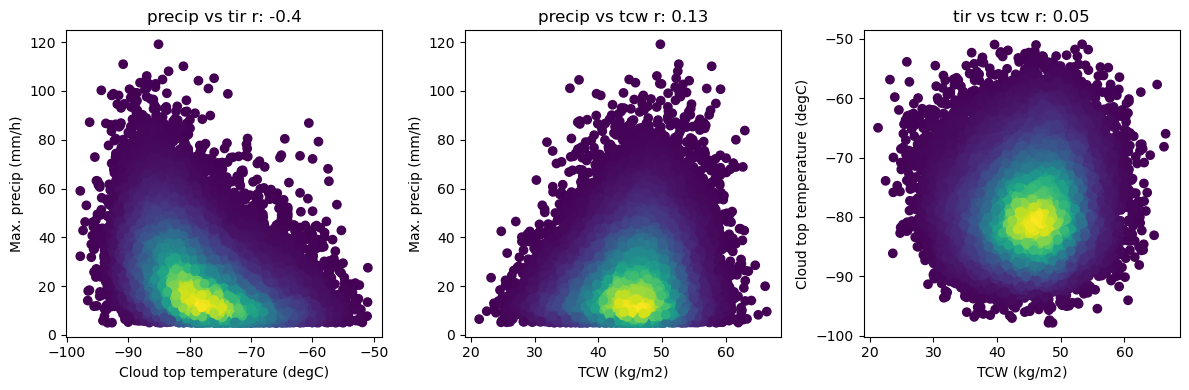

In [167]:

f = plt.figure(figsize=(12,4), dpi=100)
ax = f.add_subplot(131)
cp4s = [obs_gpm.tmin, obs_gpm.prcp] 
r = stats.pearsonr(cp4s[0],cp4s[1])
density = calc_density(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1], c=density)
plt.title('precip vs tir r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('Cloud top temperature (degC)')
plt.ylabel('Max. precip (mm/h)')

ax = f.add_subplot(132)
cp4s = [obs_gpm.tcw, obs_gpm.prcp] 
r = stats.pearsonr(cp4s[0],cp4s[1])
density = calc_density(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1], c=density)
plt.title('precip vs tcw r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('TCW (kg/m2)')
plt.ylabel('Max. precip (mm/h)')

ax = f.add_subplot(133)
cp4s = [obs_gpm.tcw, obs_gpm.tmin]
r = stats.pearsonr(cp4s[0],cp4s[1])
density = calc_density(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1], c=density)
plt.title('tir vs tcw r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('TCW (kg/m2)')
plt.ylabel('Cloud top temperature (degC)')
plt.tight_layout()
plt.savefig(cnst.network_data + 'figs/DYAMOND/dyamond_OBS2_Sahel_scatter.jpg')

In [168]:
from endgame import hist2d
p_tcw = hist2d.var2_binning_mean(obs_gpm.tcw, obs_gpm.prcp, np.linspace(33,59,15))
pslope, pintercept, pr_value, pp_value, pstd_err = stats.linregress(p_tcw['xbins'], p_tcw['y'])
tir_tcw = hist2d.var2_binning_mean(obs_gpm.tcw, obs_gpm.tmin, np.linspace(33,59,15))
tslope, tintercept, tr_value, tp_value, tstd_err = stats.linregress(tir_tcw['xbins'], tir_tcw['y'])

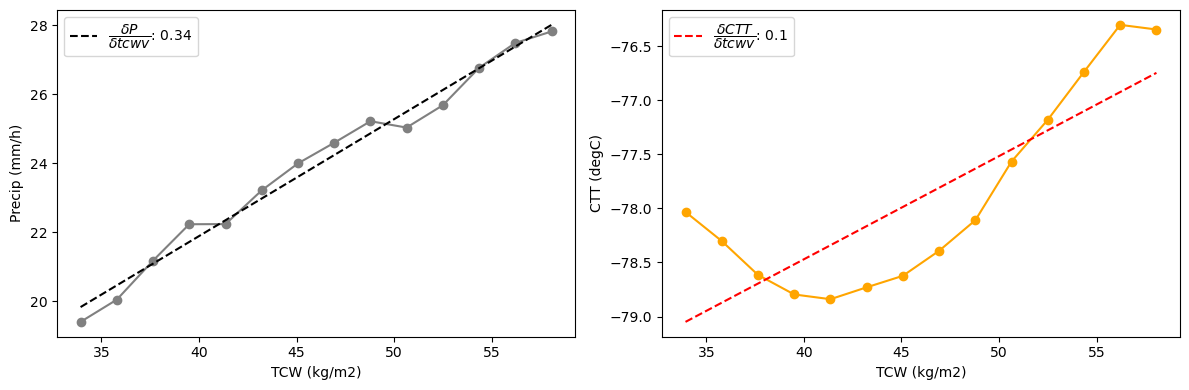

In [169]:
f = plt.figure(figsize=(12,4), dpi=100)
ax = f.add_subplot(121)
plt.plot(p_tcw['xbins'], p_tcw['y'], color='grey', marker='o')
plt.plot(p_tcw['xbins'], pintercept+np.array(p_tcw['xbins'])*pslope, linestyle='dashed', color='k', label=r'$\dfrac{\delta P}{\delta tcwv}$: ' + str(np.round(pslope,2)))
plt.xlabel('TCW (kg/m2)')
plt.ylabel('Precip (mm/h)')
plt.legend()

ax = f.add_subplot(122)
plt.plot(tir_tcw['xbins'], tir_tcw['y'], color='orange', marker='o')
plt.plot(tir_tcw['xbins'], tintercept+np.array(tir_tcw['xbins'])*tslope, linestyle='dashed', color='r', label=r'$\dfrac{\delta CTT}{\delta tcwv}$: ' + str(np.round(tslope,2)))
plt.xlabel('TCW (kg/m2)')
plt.ylabel('CTT (degC)')
plt.legend()
plt.tight_layout()
plt.savefig(cnst.network_data + 'figs/DYAMOND/dyamond_OBS2_Sahel_averageScaling_TCWbin.jpg')